In [1]:
import base64
import io
import openai
import os
import pandas as pd
import requests
import textwrap
import torch
import uuid
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionXLImg2ImgPipeline
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torch import autocast


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary C:\Users\user\AppData\Roaming\Python\Python310\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


# OpenAI - API

In [2]:
# load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_timeout = 10

In [3]:
# list engines
engines = openai.Engine.list()

# print the first engine's id
print([i.id for i in engines.data])

['curie-search-query', 'babbage-search-document', 'text-search-babbage-doc-001', 'babbage', 'text-babbage-001', 'text-similarity-davinci-001', 'davinci', 'davinci-similarity', 'code-davinci-edit-001', 'curie-similarity', 'code-search-babbage-code-001', 'curie-instruct-beta', 'text-search-ada-doc-001', 'davinci-instruct-beta', 'text-search-davinci-doc-001', 'gpt-4-0314', 'text-curie-001', 'davinci-search-query', 'text-similarity-curie-001', 'text-davinci-001', 'text-search-davinci-query-001', 'text-davinci-003', 'ada-search-document', 'ada-code-search-code', 'babbage-002', 'whisper-1', 'gpt-4-0613', 'gpt-4', 'davinci-002', 'davinci-search-document', 'curie-search-document', 'babbage-code-search-text', 'babbage-code-search-code', 'babbage-search-query', 'text-search-ada-query-001', 'code-search-ada-text-001', 'gpt-3.5-turbo-instruct-0914', 'gpt-3.5-turbo-instruct', 'gpt-3.5-turbo-0613', 'ada-search-query', 'ada-code-search-text', 'text-search-curie-query-001', 'text-davinci-002', 'code-s

In [137]:
# TODO: role of gpt + style of drawing
role = "Your task is to write prompts that will be used in text to image models for generating memes. \
        Your response can have multiple prompts in the following format for each: a prompt that describes a funny and agitative situtation starting with 'Prompt:', \
        then the caption of the corresponding meme that follows the prompt starting with 'Caption:'."
user = "Please write memes about critism of capitalism, critism of commodity fetishism, alienation, critisim of while collar people and corporate culture, or class inequality. \
        Ideologically, these memes should be positioned in economic-left. Memes should be witty, sarcastic, clever, having layers of humor and commentary . \
        Should have symbolism to convey complex ideas or emotions in a concise and humorous way. \
        Memes should be satirical or parodic in nature, mimicking or exaggerating certain visual or stylistic elements."
style = "vivid colours, anime, caricatured, full of intricate details, high resoultion, absurd and comic, simplistic and minimalistic background"

In [5]:
#df_prompt = pd.DataFrame(columns=["prompt", "caption", "seed"])
df_prompt = pd.read_csv("df_prompt.csv")
print(df_prompt.shape)

(47, 3)


In [6]:
def gpt_request():
    # ask the prompt
    response = ""
    try:
        response = openai.ChatCompletion.create(
            model= "gpt-3.5-turbo", # "gpt-4", "gpt-3.5-turbo",
            temperature=1,
            messages=[
                {"role": "system", "content": role},
                {"role": "user", "content": user},
            ]
        )
    except:
        pass
    # return result
    result = ''
    try:
        for choice in response.choices:
            result += choice.message.content
    except: 
        pass
    return result

In [7]:
#prompt = gpt_request()
#prompt

# Stability - API

In [8]:
# constants
url = "https://api.stability.ai/v1/generation/stable-diffusion-xl-1024-v1-0/text-to-image"

headers = {
  "Accept": "application/json",
  "Content-Type": "application/json",
  "Authorization": os.getenv("STABILITY_AI_API_KEY"),
}

In [10]:
def stability_prompt_body(prompt):
    return {
        "steps": 40,
        "width": 1024,
        "height": 1024,
        "seed": 0,
        "cfg_scale": 5,
        "samples": 1,
        "text_prompts": [
            {
            "text": "Draw a meme which depicts: " + prompt + style,
            "weight": 1
            },
            {
                "text": "blurry, text, text box cloud",
                "weight": -1
            }
        ],
    }

# Stable Diffusion Model

In [126]:
# load stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
#pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [138]:
def stable_diffusion_model(prompt):
    # prompt parameters
    prompt_text = prompt + style
    negative_prompt = "text, text box, text cloud, letter, caption, outline, title, subtitle"

    return pipe(prompt_text,
                negative_prompt         = negative_prompt,
                height                  = 1024,
                width                   = 1024,
                num_images_per_prompt   = 1,
                num_inference_steps     = 40,
                guidance_scale          = 7.5).images[0]  

  0%|          | 0/40 [00:00<?, ?it/s]

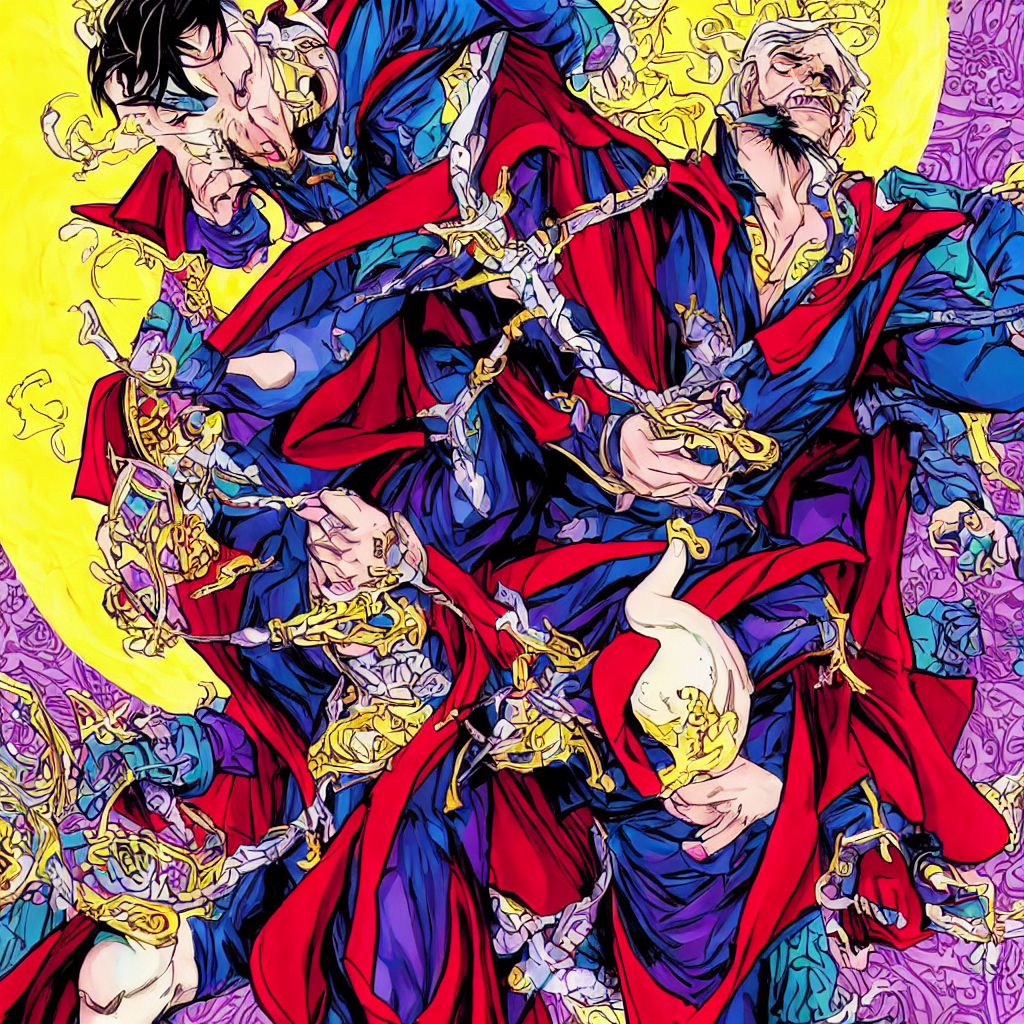

In [139]:
stable_diffusion_model("A photo of Doctor Strange eating waffle")

In [140]:
stable_diffusion_model("a boss has a ventilator on his desk while other workers sweating because of hot weather")

  0%|          | 0/40 [00:00<?, ?it/s]

# Image & Caption

In [43]:
def split_sentence(sentence):
    words = sentence.split()
    middle_index = len(words) // 2
    words.insert(middle_index, '\n')
    return ' '.join(words)

In [44]:
def add_caption_and_save(image, seed, caption):
    # create a new image with a white background, slightly taller to accommodate the caption
    width, height = image.size
    print(width, height)
    new_height = height + 100  # Adjust this value as needed
    new_image = Image.new("RGB", (width, new_height), "white")

    # paste the original image onto the new image
    new_image.paste(image, (0, 0))

    # create a drawing context on the new image
    draw = ImageDraw.Draw(new_image)

    # calculate text size and position based on font size and caption
    font = ImageFont.truetype("impact.ttf", 35)
    caption = caption.upper()
    caption_wrap = textwrap.wrap(caption, width=60)
    print(caption)
    current_h, pad = height, 10
    for line in caption_wrap:
        w, h = draw.textsize(line, font=font)
        draw.text(((width - w) / 2, current_h), line, fill="black", font=font)
        current_h += h + pad

    # save the new image with the caption
    new_image.save(f'./memes/meme_{str(seed)}.png')

    # close the original image
    new_image.close()

In [ ]:
"""
image = Image.open("memes/meme_123.png")
seed = "1234"
caption = "Capitalism: Making sure the rich never miss a chance to flex, even when it's financially disastrous."
add_caption_and_save(image, seed, caption)
"""

# Generate Memes

In [45]:
# generate memes
def generate_meme(df_prompt, model_flag):
    # meme ideas from gpt
    meme_ideas = gpt_request()
    for i in meme_ideas.split("Prompt:")[1:]:
        # seperate caption from prompt
        prompt = i.split("Caption:")[0].strip()
        caption = i.split("Caption:")[1].strip().replace('"', '')
        print("\nPrompt:", prompt)
        print("Caption:", caption)
        # draw the meme
        if not model_flag:
            # forward prompt to stability ai api
            response = requests.post(
                url,
                headers=headers,
                json=stability_prompt_body(prompt),
            )
            if response.status_code != 200:
                raise Exception("Non-200 response: " + str(response.text))
            # get image and add caption into it
            data = response.json()
            seed = data["artifacts"][0]["seed"]
            image = Image.open(io.BytesIO(base64.decodebytes(bytes(data["artifacts"][0]["base64"], "utf-8"))))
        else:
            seed = uuid.uuid4()
            image = stable_diffusion_model(prompt)
        # add caption
        add_caption_and_save(image, seed, caption)
        # add into the dataframe
        new_row = {'prompt': prompt, 'caption': caption, 'seed':seed}
        df_prompt = pd.concat([df_prompt, pd.DataFrame([new_row])], ignore_index=True)
    return df_prompt

In [46]:
df_prompt = generate_meme(df_prompt, model_flag=True)


Prompt: When your boss tells you to stay late for the third time this week because "you should be grateful for having a job":
Caption: Capitalism: Making you work harder so the rich can relax harder.


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
CAPITALISM: MAKING YOU WORK HARDER SO THE RICH CAN RELAX HARDER.

Prompt: When your paycheck barely covers your bills and you realize the company CEO just bought a new yacht:
Caption: The only thing trickling down is our tears.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)
C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
THE ONLY THING TRICKLING DOWN IS OUR TEARS.

Prompt: When you're stuck in rush hour traffic because the company won't invest in public transportation for its employees:
Caption: Commute like a boss: hours wasted, dreams shattered.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
COMMUTE LIKE A BOSS: HOURS WASTED, DREAMS SHATTERED.

Prompt: When the whole office applauds as the boss announces another round of layoffs to boost shareholder profits:
Caption: Welcome to the Hunger Games: Corporate Edition.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
WELCOME TO THE HUNGER GAMES: CORPORATE EDITION.

Prompt: When your coworker brags about being a workaholic while you quietly question your life choices:
Caption: Every office has that one person who is living in their own matrix.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
EVERY OFFICE HAS THAT ONE PERSON WHO IS LIVING IN THEIR OWN MATRIX.

Prompt: When the corporate seminar teaches you how to be a team player, but you've already mastered the art of faking enthusiasm:
Caption: When your soul dies a little more with each team building exercise.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)
C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
WHEN YOUR SOUL DIES A LITTLE MORE WITH EACH TEAM BUILDING EXERCISE.

Prompt: When the CEO shows up in casual attire and declares it "casual Friday", while you struggle to afford a decent wardrobe:
Caption: Casual Friday for them, Salvation Army chic for us.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)
C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
CASUAL FRIDAY FOR THEM, SALVATION ARMY CHIC FOR US.

Prompt: When your manager thinks the annual 2% raise is enough to keep you motivated:
Caption: When your employer confuses raises with rodents—both tend to disappear.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
WHEN YOUR EMPLOYER CONFUSES RAISES WITH RODENTS—BOTH TEND TO DISAPPEAR.

Prompt: When you overhear your boss bragging about how much they paid for their vacation, while you can't afford a weekend getaway:
Caption: Must be nice to vacation on our tears and broken dreams.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)
C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
MUST BE NICE TO VACATION ON OUR TEARS AND BROKEN DREAMS.

Prompt: When your coworker leads a PowerPoint presentation full of buzzwords and jargon, but doesn't actually say anything meaningful:
Caption: When your coworker discovers thesaurus.com and becomes a corporate poet.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


  0%|          | 0/40 [00:00<?, ?it/s]

512 512
WHEN YOUR COWORKER DISCOVERS THESAURUS.COM AND BECOMES A CORPORATE POET.


C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)
C:\Users\user\AppData\Local\Temp\ipykernel_24208\681670172.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(line, font=font)


In [ ]:
# save all prompts
df_prompt.to_csv("df_prompt.csv", index=False)